Found 8000 files belonging to 8 classes.


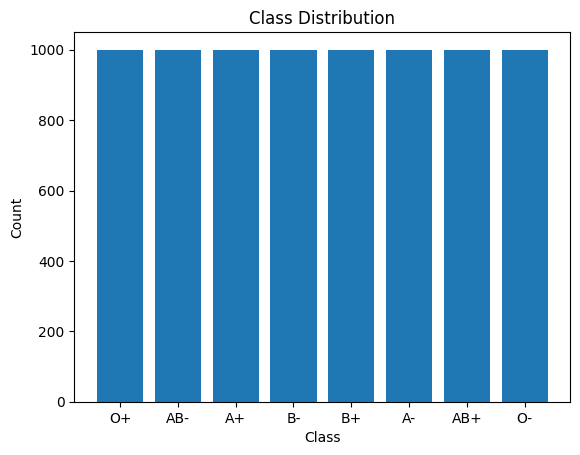

Epoch 1/50
    175/Unknown 85s 422ms/step - accuracy: 0.1645 - loss: 2.3287

c:\Users\abdhe\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


175/175 ━━━━━━━━━━━━━━━━━━━━ 125s 654ms/step - accuracy: 0.1647 - loss: 2.3276 - val_accuracy: 0.1200 - val_loss: 2.2021 - learning_rate: 1.0000e-04
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 121s 653ms/step - accuracy: 0.2346 - loss: 1.9165 - val_accuracy: 0.1225 - val_loss: 2.6476 - learning_rate: 1.0000e-04
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 118s 636ms/step - accuracy: 0.2778 - loss: 1.8246 - val_accuracy: 0.1250 - val_loss: 3.1595 - learning_rate: 1.0000e-04
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.2778 - loss: 1.7948
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
175/175 ━━━━━━━━━━━━━━━━━━━━ 120s 648ms/step - accuracy: 0.2778 - loss: 1.7946 - val_accuracy: 0.1488 - val_loss: 3.5502 - learning_rate: 1.0000e-04
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 119s 641ms/step - accuracy: 0.3192 - loss: 1.7082 - val_accuracy: 0.1500 - val_loss: 3.2589 - learning_rate: 3.0000e-05
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 119s 640ms/step -

c:\Users\abdhe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abdhe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abdhe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

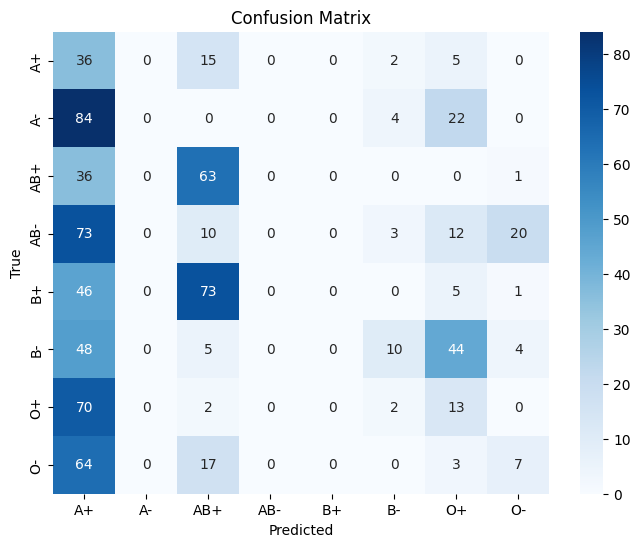

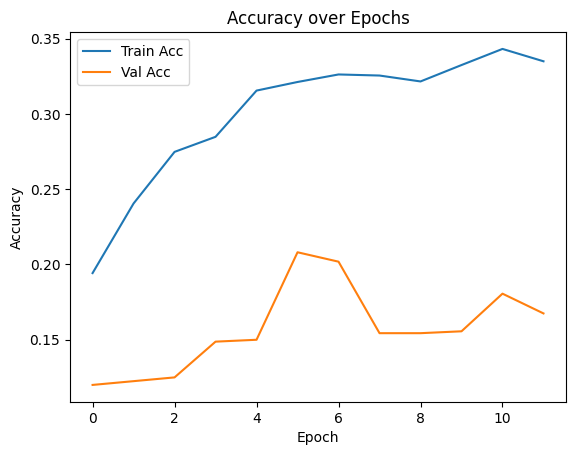

Model saved at C:\Users\abdhe\OneDrive\Documents\GitHub\BloodMark\model\model.h5


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
dataset_path = r"C:\Users\abdhe\OneDrive\Documents\GitHub\BloodMark\dataset"
save_path = r"C:\Users\abdhe\OneDrive\Documents\GitHub\BloodMark\model\model.h5"
BATCH_SIZE = 32
IMG_SIZE = (64, 64)
AUTOTUNE = tf.data.AUTOTUNE

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

class_names = dataset.class_names
class_counts = Counter()

for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

def plot_class_distribution(class_names, class_counts):
    plt.bar([class_names[i] for i in class_counts], [class_counts[i] for i in class_counts])
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

plot_class_distribution(class_names, class_counts)

# Data augmentation function
data_augment = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

# Oversample with augmentation
def oversample_with_aug(class_id, count, max_count):
    unbatched = dataset.unbatch()
    class_data = unbatched.filter(lambda img, lbl: tf.equal(lbl, class_id))
    class_data = class_data.map(lambda x, y: (data_augment(x), y), num_parallel_calls=AUTOTUNE)
    return class_data.repeat().take(max_count)

max_count = max(class_counts.values())
balanced_datasets = [oversample_with_aug(i, class_counts[i], max_count) for i in class_counts]
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Re-split dataset
total = sum(1 for _ in balanced_dataset.unbatch())
train_size = int(0.7 * total)
val_size = int(0.2 * total)

unbatched = balanced_dataset.unbatch()
train_ds = unbatched.take(train_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_test_ds = unbatched.skip(train_size)
val_ds = val_test_ds.take(val_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = val_test_ds.skip(val_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Improved Model
def create_improved_model(num_classes):
    inputs = tf.keras.Input(shape=(64, 64, 3))
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    for filters in [32, 64, 128, 256]:
        x = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D()(x)
        x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_improved_model(len(class_names))

# Callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=callbacks)

# Evaluate
loss, acc = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f} - Test Accuracy: {acc:.4f}")

# Classification Metrics
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = np.argmax(model.predict(images), axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Save model
save_path = r"C:\Users\abdhe\OneDrive\Documents\GitHub\BloodMark\model\model.h5"
high_acc_model.save(save_path)
print(f"Model saved at {save_path}")
